In [ ]:
!pip install livelossplot==0.5.1 --quiet
!pip install pytorch-model-summary 

In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [ ]:
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import gc
import pickle
import h5py
import numpy as np
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from skimage.transform import resize
from torchvision import transforms
from torch.utils.data import random_split, DataLoader, Dataset, ConcatDataset

from PIL import Image

from matplotlib import pyplot as plt

from livelossplot import PlotLosses
from pytorch_model_summary import summary

from google.colab import drive
from os import listdir
from sys import getsizeof
#drive.mount('/content/gdrive')

#Transfer Learning 






###ResNext

In [ ]:
resNext = models.resnext50_32x4d(pretrained=True).cuda()

#ONLY USING THE FIRST 7 LAYERS OF RESNEXT 

'''
        FREEZING LAYERS
'''
resNext_flag = True
alexNet_flag = False
for child in resNext.modules():
    #print(child)

    for param in child.parameters():
        param.requires_grad = False




### AlexNet

In [ ]:
#alexNet = models.alexnet(pretrained=True).cuda()
alexNet = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

new_alexNet = nn.Sequential(*list(alexNet.children())[:])
print(new_alexNet)
'''
        FREEZING LAYERS
'''
alexNet_flag = True
resNext_flag = False

for child in alexNet.modules():
    #print(child)

    for param in child.parameters():
        param.requires_grad = False



Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): AdaptiveAvgPool2d(output_size=(6, 6))
  (2): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inpla

# Functions and Training Code

In [ ]:

# custom dataset for fetching images from the .h5 file (improved performance)
class h5Dataset(Dataset):

    def __init__(self, file_path, func=None):
        # file_path: path to .h5 file
        self.file = h5py.File(file_path + "DIML.h5", "r")

        self.func = func

        self.rgb_dbs = sorted([key for key in self.file.keys() \
                                if key[:3] == "rgb"])
        self.depth_dbs = sorted([key for key in self.file.keys() \
                                if key[:5] == "depth"])
        
        self.totens = transforms.ToTensor()

    def __getitem__(self, index):
        
        #rgb = self.file[self.rgb_dbs[index]][:].astype('float64') / 255
        rgb = self.file[self.rgb_dbs[index]][:].astype('float64') 
        depth = self.file[self.depth_dbs[index]][:].astype('float64') / 65535
        
        if self.func:
            rgb, depth = self.func(rgb, depth)

        if torch.is_tensor(rgb) == False:
            rgb = self.totens(rgb)
        if torch.is_tensor(depth) == False:   
            depth = self.totens(depth)
 
        return rgb, depth

    
    def __len__(self):
        return min(len(self.rgb_dbs), len(self.depth_dbs))

class h5DatasetSlice(Dataset):

    def __init__(self, file_path, func=None, ratios=(0, 1)):
        # file_path: path to .h5 file
        self.file = h5py.File(file_path + "DIML.h5", "r")
        self.func = func

        self.rgb_dbs = sorted([key for key in self.file.keys() \
                                if key[:3] == "rgb"])
        self.depth_dbs = sorted([key for key in self.file.keys() \
                                if key[:5] == "depth"])
        ratios = [int(k*len(self.rgb_dbs)) for k in ratios]

        #print(ratios)

        self.rgb_dbs = self.rgb_dbs[ratios[0] : ratios[1]]
        self.depth_dbs = self.depth_dbs[ratios[0] : ratios[1]]
        
        self.totens = transforms.ToTensor()

    def __getitem__(self, index):
        
        #rgb = self.file[self.rgb_dbs[index]][:].astype('float64') / 255
        rgb = self.file[self.rgb_dbs[index]][:]
        #depth = self.file[self.depth_dbs[index]][:].astype('float64')
        depth = self.file[self.depth_dbs[index]][:]

        if self.func:
            rgb, depth = self.func(rgb, depth)
        else:
            rgb = self.totens(rgb)
            depth = self.totens(depth.astype(np.float64) / 65535.0)
            
        return rgb, depth

    
    def __len__(self):
        return min(len(self.rgb_dbs), len(self.depth_dbs))


def load_dataset(file_path, batch_size, ratios=(.7, .15, .15), shuffle=True):

    dataset = h5Dataset(file_path=file_path, func=alter)
    
    num_samples = len(dataset)
    len1 = int(num_samples*ratios[0])
    len2 = int(num_samples*ratios[1])

    train_data, val_data, test_data = random_split(dataset,
                                    (len1, len2, num_samples-len1-len2))
    
    print(len(train_data), len(val_data), len(test_data))
    
    train_loader = DataLoader(train_data, batch_size=batch_size, 
                              shuffle=shuffle, num_workers=0)
    val_loader = DataLoader(val_data, batch_size=batch_size, 
                              shuffle=shuffle, num_workers=0)
    test_loader = DataLoader(test_data, batch_size=batch_size, 
                              shuffle=shuffle, num_workers=0)

    return train_loader, val_loader, test_loader

def load_dataset_aug(file_path, batch_size, ratios=(.7, .15, .15), shuffle=True):
    train_data = h5DatasetSlice(file_path=file_path, func=alter_aug, 
                                ratios=(0, ratios[0]))
    val_data = h5DatasetSlice(file_path=file_path, 
                                ratios=(ratios[0], ratios[0]+ratios[1]))
    test_data = h5DatasetSlice(file_path=file_path, 
                                ratios=(ratios[0]+ratios[1], 1))
    
    print(len(train_data), len(val_data), len(test_data))
    
    train_loader = DataLoader(train_data, batch_size=batch_size, 
                              shuffle=shuffle, num_workers=0, drop_last=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, 
                              shuffle=shuffle, num_workers=0, drop_last=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, 
                              shuffle=shuffle, num_workers=0, drop_last=True)

    return train_loader, val_loader, test_loader

# calculates the loss of first batch in validation
# in the future, find a better way to get validation loss (test more data,
# without being time consuming)
def batch_loss(model, criterion, val_loader):

    with torch.no_grad():

        for i, (rgb, depth) in enumerate(val_loader):

            if torch.cuda.is_available():
                rgb = rgb.cuda()
                depth = depth.cuda()
            
            pred = model(rgb.float())
            del rgb

            val_loss = torch.sqrt(criterion(depth.squeeze(), pred.squeeze())).item()
            del pred, depth

            return val_loss


class Interpolate(nn.Module):
    def __init__(self, scale, mode):
        super(Interpolate, self).__init__()
        self.interp = F.interpolate
        self.scale = scale
        self.mode = mode
        
    def forward(self, x):
        x = self.interp(x, scale_factor=self.scale, mode=self.mode, align_corners=False)
        return x

# rewrite data augmentation transformations to perform same action on image pairs
def random_crop(data, size):
    rgb, depth = data
    h, w = rgb.shape[:2]
    new_h, new_w = size

    top = np.random.randint(0, h - new_h)
    left = np.random.randint(0, w - new_w)

    rgb = rgb[top: top + new_h,
              left: left + new_w]
    depth = depth[top: top + new_h,
                  left: left + new_w]
    
    return rgb, depth

def random_rotate(data, max_angle, resample=False, expand=False, 
                  center=None, fill=None):
    rgb, depth = data
    rgb = Image.fromarray(rgb)
    depth = Image.fromarray(depth)
    angle = np.random.uniform(-max_angle, max_angle)
    return (TF.rotate(rgb, angle, resample, expand, center, fill), TF.rotate(depth, angle, resample, expand, center, fill))

def random_hflip(data, p=0.5):
    rgb, depth = data

    if torch.rand(1) < p:
        return TF.hflip(rgb), TF.hflip(depth)
    
    return rgb, depth

def alter(rgb, depth):
    '''
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (10, 10))
    depth = np.float64(cv.morphologyEx(np.uint8(depth), cv.MORPH_OPEN, kernel))
    norm = transforms.Normalize((0.5), (0.5))
    sig = nn.Sigmoid()
    '''
    norm = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])

    depth_norm = transforms.Normalize(0,0.1217)

    if resNext_flag:
        #depth = (depth - torch.min(depth)+0.001)/torch.max(depth)

        rgb = norm(rgb)

    elif alexNet_flag:
        
        resize = transforms.Resize((256,256))
       
        rgb = Image.fromarray(rgb.astype(np.uint8))
        depth = Image.fromarray(depth)

        depth = resize(depth)
        rgb = resize(rgb)

        tens = transforms.ToTensor()
        
        rgb = tens(rgb)
        depth = tens(depth)
        rgb = norm(rgb)        #Normalize rgb

       

    #Normalize depth images 
    #depth = (depth - torch.min(depth))/(torch.max(depth)-torch.min(depth))
    depth = depth_norm(depth)
    return rgb, depth

def alter_aug(rgb, depth):
    totens = transforms.ToTensor()
    #resize = transforms.Resize((224, 224))

    # data augmentation

    rgb, depth = random_crop((rgb, depth), (384, 384))
    rgb, depth = random_rotate((rgb, depth), max_angle=15, fill=1)
    #plt.imshow(np.moveaxis(np.array(depth), 0, -1), cmap='gray')
    rgb, depth = random_hflip((rgb, depth))

    rgb = resize(np.array(rgb), (224, 224))
    depth = resize(np.array(depth), (224, 224))

    rgb = totens(rgb)
    depth = totens(depth)

    #depth = (depth - torch.min(depth))/(torch.max(depth) - torch.min(depth))
    depth = depth / torch.max(depth)

    #depth = depth / 65535.0

    return rgb, depth


# train the model (one epoch is usually enough because of repeating images)
def train(model, batch_size=16, learning_rate=0.01, 
          num_epochs=1, ratios=(.7, .15, .15)):

    #torch.autograd.set_detect_anomaly(True)

    plotlosses = PlotLosses()

    print("loading data...")


    train_loader, val_loader = load_dataset(
        file_path=nada_path,
        batch_size=batch_size,
        ratios=ratios
        )[:2]

    print("data loading complete")

    torch.manual_seed(69)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, \
                                        factor=0.5, patience=5, verbose=True)

    for epoch in range(num_epochs):

        for i, (rgb, depth) in enumerate(train_loader):

            if torch.cuda.is_available():
                rgb = rgb.cuda()
                depth = depth.cuda()
            
            optimizer.zero_grad()

            pred = model(rgb.float())
            del rgb

            loss = torch.sqrt(criterion(depth.squeeze(), pred.squeeze()))
            del pred, depth

            gc.collect()

            val_loss = batch_loss(model, nn.MSELoss(), val_loader)

            scheduler.step(val_loss)
        
            
            loss.backward()
            optimizer.step()
            plotlosses.update({
                'loss': loss.item(),
                'val_loss': val_loss
            })
            plotlosses.send()


##CLASS FOR PRINTING LAYERS
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        print_depth(x.detach().numpy())
        #print(x)
        return x

#### -----------------------------------------------####
####                     RESNEXT                    #### 
#### -----------------------------------------------####

class GeneratorResNext(nn.Module):
    def __init__(self, activ=nn.LeakyReLU()):
        super(GeneratorResNext, self).__init__()

        self.new_resNext = nn.Sequential(*list(resNext.children())[:7])


        self.trans_conv = nn.Sequential(
            Interpolate(scale=2, mode='bilinear'),
            nn.ConvTranspose2d(1025, 80, kernel_size=3, padding=1, 
                               stride=3, output_padding=1),
            activ,
            nn.BatchNorm2d(80),
            nn.ConvTranspose2d(80, 40, kernel_size=7, padding=3, 
                               stride=2, output_padding=1),
            activ,
            nn.BatchNorm2d(40),
            nn.ConvTranspose2d(40, 1, kernel_size=11, padding=5, 
                               stride=2, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, rgb):
        x = self.new_resNext(rgb)
        noise = torch.FloatTensor(
                np.random.normal(0, 1, (x.shape[0], 1, 30, 40))).cuda()        
        return self.trans_conv(torch.cat((x, noise), dim=1))
        


class DiscriminatorResNext(nn.Module):
    def __init__(self, activ=nn.LeakyReLU()):
        super(DiscriminatorResNext, self).__init__()

        self.conv = nn.Sequential(
            nn.MaxPool2d(4, 4),
            nn.BatchNorm2d(4),
            nn.Conv2d(4, 8, kernel_size=5, padding=2, stride=2),
            activ,
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 15, kernel_size=3, padding=1, stride=2),
        )
        self.linear = nn.Sequential(
            nn.Linear(15*20*15, 10),
            activ,
            nn.Linear(10, 1),
            nn.Sigmoid()
        )

    def forward(self, rgb, depth):

        #noise = torch.FloatTensor(
                #np.random.normal(0, 1, (rgb.shape[0], 1, 480, 640))).cuda()

        x = self.conv(torch.cat((rgb, depth), dim=1))
        x = self.linear(x.view(x.size(0), -1))
        return x
#### -----------------------------------------------####
####                    ALEXNET                     #### 
#### -----------------------------------------------####

'''
    if torch.cuda.is_available():
        noise = torch.FloatTensor(
                np.random.normal(0, 1, (x.shape[0], 1, 6, 6))).cuda()   
    else:
        noise = torch.FloatTensor(
                np.random.normal(0, 1, (x.shape[0], 1, 6, 6)))  
        print('noise:',noise.shape)

    x =  self.trans_conv(torch.cat((x, noise), dim=1))  
'''
#with resize convolution
class GeneratorAlexNet(nn.Module):
    def __init__(self, activ=nn.LeakyReLU()):
        super(GeneratorAlexNet, self).__init__()

        self.new_alexNet = nn.Sequential(*list(alexNet.children())[:2][:7])


        self.trans_conv = nn.Sequential(
            Interpolate(scale=1.5, mode='bilinear'),
            nn.ReflectionPad2d(4),
            nn.Conv2d(256, 80, kernel_size=3, padding=1, 
                               stride=1),
            activ,
            nn.ReflectionPad2d(4),
            nn.Conv2d(80, 40, kernel_size=5, padding=2, 
                               stride=1),
            
            activ,
            nn.ReflectionPad2d(10),
            nn.ConvTranspose2d(40, 20, kernel_size=5, padding=2,
                               stride=2, output_padding=1),
            activ,
            nn.BatchNorm2d(20),
            nn.ConvTranspose2d(20, 1, kernel_size=5, padding=2,
                               stride=2, output_padding=1),
            PrintLayer(),
            Interpolate(scale=1.20755, mode='bilinear'),
            PrintLayer(),
            nn.Sigmoid()
        )

    def forward(self, rgb):
        x = self.new_alexNet(rgb)
        print('forward gen')
        #print_rgb(x.detach().numpy())
        
        ## insert here, noise code above
        x = self.trans_conv(x)
        print('Generator out:',x.shape)   

        return x

## with transpose conv
class GeneratorAlexNetTrans(nn.Module):
    def __init__(self, activ=nn.LeakyReLU()):
        super(GeneratorAlexNetTrans, self).__init__()

        self.new_alexNet = nn.Sequential(*list(alexNet.children())[:2][:7])

        self.trans_conv = nn.Sequential(
            Interpolate(scale=1.5, mode='bilinear'),
            nn.ConvTranspose2d(256, 80, kernel_size=3, padding=1, 
                               stride=2, output_padding=1),
            activ,
            nn.BatchNorm2d(80),
            nn.ConvTranspose2d(80, 40, kernel_size=5, padding=2, 
                               stride=3, output_padding=1),
            activ,
            nn.BatchNorm2d(40),
            nn.ConvTranspose2d(40, 20, kernel_size=5, padding=2,
                               stride=2, output_padding=1),
            activ,
            nn.BatchNorm2d(20),
            nn.ConvTranspose2d(20, 1, kernel_size=5, padding=2,
                               stride=2, output_padding=1),
            Interpolate(scale=1.20755, mode='bilinear'),
            nn.Sigmoid()
        )

    def forward(self, rgb):
        x = self.new_alexNet(rgb)
        print('forward gen')
        #print_rgb(x.detach().numpy())
        
        ## insert here, noise code above
        x = self.trans_conv(x)
        print('Generator out:',x.shape)   

        return x


class DiscriminatorAlexNet(nn.Module):
    def __init__(self, activ= nn.LeakyReLU()):
        super(DiscriminatorAlexNet, self).__init__()

        self.conv = nn.Sequential(
            nn.MaxPool2d(4, 4),
            nn.BatchNorm2d(4),
            nn.Conv2d(4, 8, kernel_size=5, padding=2, stride=2),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 15, kernel_size=3, padding=1, stride=2),
        )
        self.linear = nn.Sequential(
            nn.Linear(4*4*15, 10),
            activ,
            nn.Linear(10, 1),
            nn.Sigmoid()
        )

    def forward(self, rgb, depth):
        rgb = torch.nn.functional.interpolate(rgb, (112,112))
        depth = torch.nn.functional.interpolate(depth, (112,112))
        
       
        cat = torch.cat((rgb,depth), dim=1)

        x = self.conv(cat)
        x = self.linear(x.view(x.size(0), -1))
        return x


def trainGAN2(generator, discriminator, batch_size=16, gen_lr=0.01, dis_lr=0.01,
             stepped_epochs=50, num_epochs=1, ratios=(.7, .15, .15)):
    
    groups = {'Losses':['gen','dis']}
    plotlosses = PlotLosses(groups=groups)

    print("loading data...")

    train_loader, val_loader = load_dataset(
        file_path=nada_path,
        batch_size=batch_size,
        ratios=ratios
        )[:2]

    print("data loading complete")

    torch.manual_seed(69)

    criterion = nn.BCELoss()

    gen_optim = optim.Adam(generator.parameters(), lr=gen_lr, betas=(0.5, 0.999))
    dis_optim = optim.Adam(discriminator.parameters(), lr=dis_lr, betas=(0.5, 0.999))

    
    gen_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=gen_optim,
                                        factor=0.025, patience=5, verbose=True)
    dis_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=dis_optim,
                                        factor=0.025, patience=7, verbose=True)
    

    # set models in training mode
    generator.train()
    discriminator.train()

    # float tensors for correct(1)/incorrect(0) discriminator labels
    true_labels = torch.FloatTensor(np.ones(shape=(batch_size,1)))
    false_labels = torch.FloatTensor(np.zeros(shape=(batch_size,1)))

    if torch.cuda.is_available():
        true_labels = true_labels.cuda()
        false_labels = false_labels.cuda()
    
    # initialize loss values for selective training 
    gen_loss_item = 1.0
    dis_loss_item = 1.0

    # keep track of better gen and dis losses
    best_gen = 1.0
    best_dis = 1.0

    for epoch in range(num_epochs):

        for i, (rgb, depth) in enumerate(train_loader, 0):
            print(i, 'iteration')
           # print_result(rgb, depth, train_loader)

            j = epoch * int (len(train_loader.dataset) / batch_size) + i

            # move tensors to GPU
            if torch.cuda.is_available():
                rgb = rgb.cuda()
                depth = depth.cuda()

            '''
            TRAIN GENERATOR
            '''
            if (gen_loss_item >= dis_loss_item and j < stepped_epochs) or j > stepped_epochs:
            
                gen_optim.zero_grad()
            
                #generate batch of depth maps
                gen_depth = generator(rgb.float())
                 
                #### FUNCTION TO PRINT GENERATED RESULT
                #print_depth(gen_depth[0].detach().numpy())
                # pass images through discriminator and check loss
                validity = discriminator(rgb.float(), gen_depth)
        
                gen_loss = criterion(validity, true_labels)
                gen_loss_item = gen_loss.item()

                gen_sched.step(gen_loss_item)

                gen_loss.backward()
                gen_optim.step()

            '''
            TRAIN DISCRIMINATOR
            '''

            if (dis_loss_item >= gen_loss_item and j < stepped_epochs) or \
                                                        j > stepped_epochs:

                dis_optim.zero_grad()

                # loss for real images
                ## !!!!
                ## problem this outputs 31 elements not 64 (batch size), since true_labels 
                ## has a size of 64. Problem occurs when criterion is called. (real_dis_loss= cirt(.....))
                ## !!!!

                validity_real = discriminator(rgb.float(), depth.float())
                
                real_dis_loss = criterion(validity_real, true_labels)

                # loss for generated images
                validity_fake = discriminator(rgb.float(), gen_depth.detach())
                fake_dis_loss = criterion(validity_fake, false_labels)

                # average the two losses
                dis_loss = (real_dis_loss + fake_dis_loss) / 2
                dis_loss_item = dis_loss.item()

                dis_sched.step(dis_loss_item)

                dis_loss.backward()
                dis_optim.step()

            plotlosses.update({
                'gen': gen_loss.item(),
                'dis': dis_loss.item()
            })
            plotlosses.send()

            if torch.cuda.is_available():
                torch.cuda.synchronize()


def trainGAN_aug(generator, discriminator, batch_size=16, gen_lr=0.01, dis_lr=0.01,
             stepped_epochs=50, num_epochs=1, ratios=(.7, .15, .15)):
    
    groups = {'Losses':['gen','dis']}
    plotlosses = PlotLosses(groups=groups)

    print("loading data...")

    train_loader, val_loader = load_dataset_aug(
        file_path=nada_path,
        batch_size=batch_size,
        ratios=ratios
        )[:2]

    print("data loading complete")

    torch.manual_seed(69)

    criterion = nn.BCELoss()

    gen_optim = optim.Adam(generator.parameters(), lr=gen_lr, betas=(0.5, 0.999))
    dis_optim = optim.Adam(discriminator.parameters(), lr=dis_lr, betas=(0.5, 0.999))

    
    gen_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=gen_optim,
                                        factor=0.025, patience=5, verbose=True)
    dis_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=dis_optim,
                                        factor=0.025, patience=7, verbose=True)
    

    # set models in training mode
    generator.train()
    discriminator.train()

    # float tensors for correct(1)/incorrect(0) discriminator labels
    true_labels = torch.FloatTensor(np.ones(shape=(batch_size,1)))
    false_labels = torch.FloatTensor(np.zeros(shape=(batch_size,1)))

    if torch.cuda.is_available():
        true_labels = true_labels.cuda()
        false_labels = false_labels.cuda()
    
    # initialize loss values for selective training 
    gen_loss_item = 1.0
    dis_loss_item = 1.0

    # keep track of better gen and dis losses
    best_gen = 1.0
    best_dis = 1.0

    for epoch in range(num_epochs):

        for i, (rgb, depth) in enumerate(train_loader, 0):
            print(i, 'iteration')
            print_result(rgb, depth, train_loader)

            j = epoch * int (len(train_loader.dataset) / batch_size) + i

            # move tensors to GPU
            if torch.cuda.is_available():
                rgb = rgb.cuda()
                depth = depth.cuda()

            '''
            TRAIN GENERATOR
            '''
            if (gen_loss_item >= dis_loss_item and j < stepped_epochs) or j > stepped_epochs:
            
                gen_optim.zero_grad()
            
                #generate batch of depth maps
                gen_depth = generator(rgb.float())
                

                # pass images through discriminator and check loss
                #inputs to discriminator get concatenated in forward function
                validity = discriminator(rgb.float(), gen_depth)
        
                gen_loss = criterion(validity, true_labels)
                gen_loss_item = gen_loss.item()

                gen_sched.step(gen_loss_item)

                gen_loss.backward()
                gen_optim.step()

            '''
            TRAIN DISCRIMINATOR
            '''

            if (dis_loss_item >= gen_loss_item and j < stepped_epochs) or \
                                                        j > stepped_epochs:

                dis_optim.zero_grad()

                # loss for real images
                ## !!!!
                ## problem this outputs 31 elements not 64 (batch size), since true_labels 
                ## has a size of 64. Problem occurs when criterion is called. (real_dis_loss= cirt(.....))
                ## !!!!

                validity_real = discriminator(rgb.float(), depth.float())
                
                real_dis_loss = criterion(validity_real, true_labels)

                # loss for generated images
                validity_fake = discriminator(rgb.float(), gen_depth.detach())
                fake_dis_loss = criterion(validity_fake, false_labels)

                # average the two losses
                dis_loss = (real_dis_loss + fake_dis_loss) / 2
                dis_loss_item = dis_loss.item()

                dis_sched.step(dis_loss_item)

                dis_loss.backward()
                dis_optim.step()

            plotlosses.update({
                'gen': gen_loss.item(),
                'dis': dis_loss.item()
            })
            plotlosses.send()

            if torch.cuda.is_available():
                torch.cuda.synchronize()




nada_path = "/content/gdrive/My Drive/Industrial Engineering/Second Year/APS360/APS360_Project/Data/"

#Training

### ResNext

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

generator = GeneratorResNext()
discriminator = DiscriminatorResNext()

if torch.cuda.is_available():
    print("GPU available")
    generator.cuda()
    discriminator.cuda()

trainGAN(generator, discriminator, batch_size=16, gen_lr=0.01, dis_lr=0.01, num_epochs=1, ratios=(.7, .15, .15))

NameError: ignored

### AlexNet

##### Layer Sizes Check

In [ ]:
class SkipUpconv2(nn.Module):
    def __init__(self, in_channels, out_channels, activ=nn.LeakyReLU(0.2)):
        super(SkipUpconv2, self).__init__()

        mid_channels = (in_channels + out_channels) // 2
        self.activ = activ
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels = mid_channels,
            kernel_size = 3,
            stride = 1,
            padding = 1,
        )
        self.conv2 = nn.Conv2d(
            in_channels=mid_channels,
            out_channels = out_channels,
            kernel_size = 3,
            stride = 1,
            padding = 1,
        )

    def forward(self, small, big):
        #print(small.shape, big.shape)
        scaled = F.interpolate(small, size=big.shape[2:], mode='bilinear', 
                               align_corners=True)
        x = self.activ(self.conv1(torch.cat((scaled, big), dim=1)))
        x = self.activ(self.conv2(x))

        return F.interpolate(x, scale_factor=2, mode='bilinear', 
                             align_corners=True)
        
class SkipEncoder5(nn.Module):
    def __init__(self, channels=(640, 300, 150, 50)):
        super(SkipEncoder5, self).__init__()

        self.mobilenet = models.mobilenet_v2(pretrained=True)

        self.norm1 = nn.BatchNorm2d(channels[1])
        self.norm2 = nn.BatchNorm2d(channels[3])

        self.dec1 = nn.Conv2d(1280, channels[0], kernel_size=3, stride=1, 
                              padding=1)
        self.dec2 = SkipUpconv2(channels[0]+96, channels[1])
        self.dec3 = SkipUpconv2(channels[1]+32, channels[2])
        self.dec4 = SkipUpconv2(channels[2]+24, channels[3])
        self.dec5 = SkipUpconv2(channels[3]+16, 1)

        self.sig = nn.Sigmoid()
    
    def forward(self, x0):
        features = [x0]
        for name, module in self.mobilenet.features._modules.items():
            features.append(module(features[-1]))
        
        x1 = self.dec1(features[19])
        x2 = self.norm1(self.dec2(x1, features[14]))
        x3 = self.dec3(x2, features[7])
        x4 = self.norm2(self.dec4(x3, features[4]))
        x5 = self.dec5(x4, features[2])

        print(x0.shape, x1.shape, x2.shape, x3.shape, x4.shape, x5.shape)

        return self.sig(x5)

summary(SkipEncoder5(), torch.zeros(3,3,224,224),show_input= False, show_hierarchical=False, print_summary=True)

torch.Size([3, 3, 224, 224]) torch.Size([3, 640, 7, 7]) torch.Size([3, 300, 28, 28]) torch.Size([3, 150, 56, 56]) torch.Size([3, 50, 112, 112]) torch.Size([3, 1, 224, 224])
-------------------------------------------------------------------------
      Layer (type)          Output Shape         Param #     Tr. Param #
          Conv2d-1        [3, 640, 7, 7]       7,373,440       7,373,440
     SkipUpconv2-2      [3, 300, 28, 28]       4,830,650       4,830,650
     BatchNorm2d-3      [3, 300, 28, 28]             600             600
     SkipUpconv2-4      [3, 150, 56, 56]       1,045,849       1,045,849
     SkipUpconv2-5     [3, 50, 112, 112]         225,954         225,954
     BatchNorm2d-6     [3, 50, 112, 112]             100             100
     SkipUpconv2-7      [3, 1, 224, 224]          19,933          19,933
         Sigmoid-8      [3, 1, 224, 224]               0               0
Total params: 13,496,526
Trainable params: 13,496,526
Non-trainable params: 0
------------------

'-------------------------------------------------------------------------\n      Layer (type)          Output Shape         Param #     Tr. Param #\n=========================================================================\n          Conv2d-1        [3, 640, 7, 7]       7,373,440       7,373,440\n     SkipUpconv2-2      [3, 300, 28, 28]       4,830,650       4,830,650\n     BatchNorm2d-3      [3, 300, 28, 28]             600             600\n     SkipUpconv2-4      [3, 150, 56, 56]       1,045,849       1,045,849\n     SkipUpconv2-5     [3, 50, 112, 112]         225,954         225,954\n     BatchNorm2d-6     [3, 50, 112, 112]             100             100\n     SkipUpconv2-7      [3, 1, 224, 224]          19,933          19,933\n         Sigmoid-8      [3, 1, 224, 224]               0               0\n=========================================================================\nTotal params: 13,496,526\nTrainable params: 13,496,526\nNon-trainable params: 0\n---------------------------

In [ ]:
#Discriminator Check

summary(DiscriminatorAlexNet(),torch.zeros((64,3,256,256)),torch.zeros((64,1,256,256)), show_input = True,show_hierarchical= False, print_summary=True)
#torch.zeros((1,1,256,256)),torch.zeros((1,1,256,256))


In [ ]:
#Generator Check

generator = GeneratorAlexNetTrans()
print(summary(generator, torch.zeros((1, 3, 256, 256)), show_input = False, show_hierarchical = True))


###### TRAINING

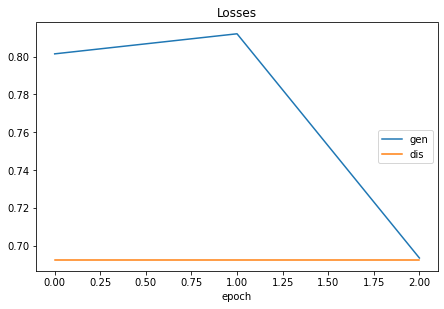

Losses
	gen              	 (min:    0.693, max:    0.812, cur:    0.693)
	dis              	 (min:    0.693, max:    0.693, cur:    0.693)
3 iteration
torch.Size([64, 3, 224, 224]) torch.Size([64, 1, 224, 224])
forward gen
line4 (180, 180)


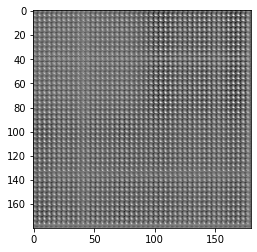

line4 (217, 217)


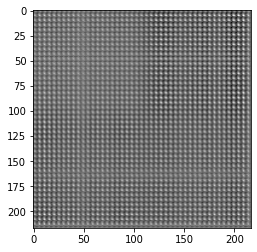

Generator out: torch.Size([1, 1, 217, 217])


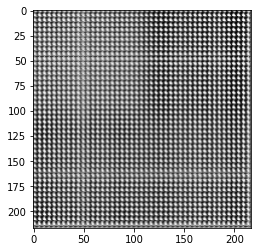

forward gen
line4 (180, 180)


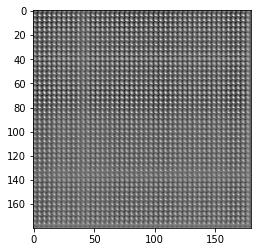

line4 (217, 217)


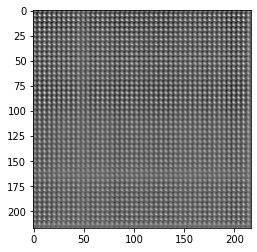

Generator out: torch.Size([64, 1, 217, 217])


RuntimeError: ignored

In [ ]:

discriminator = DiscriminatorAlexNet()

generator = GeneratorAlexNet()

if torch.cuda.is_available():
    print("GPU available")
    generator.cuda()
    discriminator.cuda()

trainGAN_aug(generator, discriminator, batch_size=64, gen_lr=0.005, dis_lr=0.006, num_epochs=1, ratios=(.7, .15, .15))


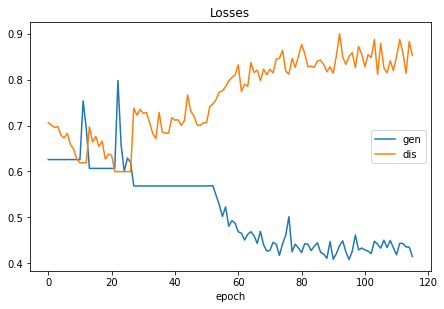

Losses
	gen              	 (min:    0.408, max:    0.798, cur:    0.415)
	dis              	 (min:    0.600, max:    0.900, cur:    0.853)


KeyboardInterrupt: ignored

In [ ]:
'''import gc
gc.collect()
torch.cuda.empty_cache()
'''

discriminator = DiscriminatorAlexNet()
generator = GeneratorAlexNetTrans()

if torch.cuda.is_available():
    print("GPU available")
    generator.cuda()
    discriminator.cuda()

trainGAN2(generator, discriminator, batch_size=8, gen_lr=0.001, dis_lr=0.001, num_epochs=1, ratios=(.7, .15, .15))



In [ ]:
'''import gc
gc.collect()
torch.cuda.empty_cache()
'''

discriminator = DiscriminatorAlexNetTrans()
generator = GeneratorAlexNet()

if torch.cuda.is_available():
    print("GPU available")
    generator.cuda()
    discriminator.cuda()

trainGAN3(generator, discriminator, batch_size=32, gen_lr=0.0002, dis_lr=0.0002, num_epochs=1, ratios=(.7, .15, .15))

## RESULT CHECKING

####Non GAN

In [ ]:
train_loader, val_loader, test_loader = load_dataset(
        file_path=nada_path,
        batch_size=64,
        ratios=(.7, .15, .15),
        shuffle=False
        )

for i, (rgb, depth) in enumerate(test_loader):
   # out = resNext(rgb)

    print(rgb.shape, depth.shape)
    
    rgb1 = np.moveaxis(np.array(rgb[0]), 0, -1)
    depth1 = np.moveaxis(np.array(depth[0]), 0, -1).squeeze()

   
    transform = transforms.ToTensor()

    print(torch.max(rgb[0,2]).item())
    print(torch.min(rgb[0,2]).item())

    print(torch.max(depth[0]).item())
    print(torch.min(depth[0]).item())
    
    pred = np.array(new_resNext(transform(rgb1).cuda().float().unsqueeze(0)).detach().cpu()).squeeze()
    #print(depth1, pred)
    print(pred.shape)

    plt.imshow(rgb1)
    plt.show()
    plt.imshow(depth1, cmap='gray')
    plt.show()
    plt.imshow(pred, cmap='gray')
    plt.show()
   
    break

####GAN RESULT CHECKING

In [ ]:

def print_full_depth(img):
    for i in range(img.shape[0]):
        img1 = np.moveaxis(np.array(img[0]), 0, -1).squeeze()
        print('line4',img1.shape)
        plt.imshow(img1[i], cmap='gray')
        plt.show() 

def print_depth(img):
    img1 = np.moveaxis(np.array(img[0]), 0, -1).squeeze()
    print('line4',img1.shape)
    plt.imshow(img1, cmap='gray')
    plt.show() 

def print_rgb(rgb):
   
    rgb = np.moveaxis(np.array(rgb[0]), 0, -2).squeeze()
    print(rgb.shape)
    transform = transforms.ToTensor()
    rgb = transform(rgb).float()
    print(rgb.shape)
    print('in print rgb')
    plt.imshow(rgb[:,:,1])
    plt.show()


In [ ]:
_#function to print while training

def print_result(rgb, depth, loader):

    for i, (rgb, depth) in enumerate(loader):

        print(rgb.shape, depth.shape)

        rgb1 = np.moveaxis(np.array(rgb[1]), 0, -1)
        depth1 = np.moveaxis(np.array(depth[0]), 0, -1).squeeze()

        transform = transforms.ToTensor()

        rgb = transform(rgb1).float().unsqueeze(0)
        #pred = np.array(generator(rgb).detach(.cpu()).squeeze()
        pred = np.array(generator(rgb).detach()).squeeze()
        #print(depth1)
        #print(pred.shape)
        '''
        plt.imshow(rgb1)
        plt.show()
        plt.imshow(depth1, cmap='gray')
        plt.show()
        '''
        plt.imshow(pred, cmap='gray')
        plt.show() 
        
        break

2527 542 542
torch.Size([64, 3, 224, 224]) torch.Size([64, 1, 224, 224])
forward gen
line4 (180, 180)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


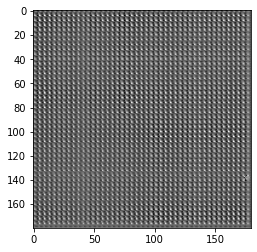

line4 (217, 217)


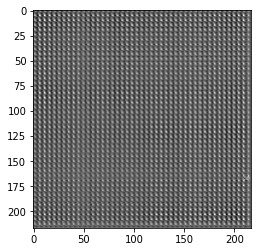

Generator out: torch.Size([1, 1, 217, 217])
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(217, 217)


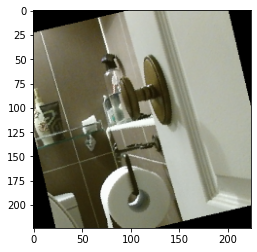

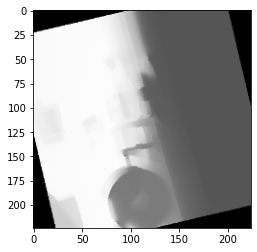

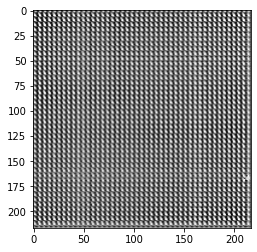

In [ ]:
train_loader, val_loader, test_loader = load_dataset_aug(
        file_path=nada_path,
        batch_size=64,
        ratios=(.7, .15, .15),
        shuffle=False
        )

for i, (rgb, depth) in enumerate(train_loader):

    print(rgb.shape, depth.shape)

    rgb1 = np.moveaxis(np.array(rgb[0]), 0, -1)
    depth1 = np.moveaxis(np.array(depth[0]), 0, -1).squeeze()

    transform = transforms.ToTensor()

    rgb = transform(rgb1).float().unsqueeze(0)
    #pred = np.array(generator(rgb).detach().cpu()).squeeze()
    pred = np.array(generator(rgb).detach()).squeeze()
    print(depth1)
    print(pred.shape)

    plt.imshow(rgb1)
    plt.show()
    plt.imshow(depth1, cmap='gray')
    plt.show()
    plt.imshow(pred, cmap='gray')
    plt.show() 
    
    break

In [ ]:
!ps -aux|grep python

In [ ]:
!kill -9 130

In [ ]:
!nvidia-smi

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from pytorch_model_summary import summary


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


# show input shape
print(summary(Net(), torch.zeros((1, 1, 28, 28)), show_input=True))

# show output shape
print(summary(Net(), torch.zeros((1, 1, 28, 28)), show_input=False))

# show output shape and hierarchical view of net
print(summary(Net(), torch.zeros((1, 1, 28, 28)), show_input=False, show_hierarchical=True))